In [2070]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import emoji
import unidecode
import string
from nltk.stem import PorterStemmer
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
pd.set_option("display.max_colwidth", 10000)

In [2071]:
imdb_df = pd.read_csv('imdb_labelled.txt', sep ='\t' , names=['review', 'sentiment'])
yelp_df = pd.read_csv('yelp_labelled.txt', sep ='\t', names=['review', 'sentiment'])
amazon_df = pd.read_csv('amazon_cells_labelled.txt', sep ='\t', names=['review', 'sentiment'])

# Exploration

In [2072]:
frames = [imdb_df, yelp_df, amazon_df]
df = pd.concat(frames)
reviews = df['review'].to_string(index=False)
df.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1


In [2073]:
# Find review lengths
review_lengths = df.review.str.len()
print('Longest review: ', str(max(review_lengths)) + ' characters')
print('Average review: ', str(sum(review_lengths) / df.review.count()) + ' characters')
# Find the number of positive and negative reviews
print('Number of positive and negative reviews:\n', df.sentiment.value_counts())


Longest review:  479 characters
Average review:  65.26466666666667 characters
Number of positive and negative reviews:
 1    1500
0    1500
Name: sentiment, dtype: int64


In [2074]:
# Tokenize reviews
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(df.review)
# put tokens into index-based sequences
sequences = tokenizer.texts_to_sequences(df.review)

# Longest reviews
max_len = max(len(x) for x in sequences)
sum_len = sum(len(x) for x in sequences)
print('The longest review is ', str(max_len) + ' words.')

# Average review
print('The average review is ', str((sum_len) / 3000) + ' words.')
# Vocabulary size
word_token_count = tokenizer.word_counts
vocab_size = (len(word_token_count))
print('The vocabulary size is ', str(vocab_size) + ' words.')

The longest review is  73 words.
The average review is  11.891 words.
The vocabulary size is  5270 words.


In [2075]:
# convert sequences to numpy array
word_matrix = tokenizer.sequences_to_matrix(sequences, mode='count')
word_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 3., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [2076]:
# Tokenize reviews - characters
punc_tokenizer = Tokenizer(char_level=True)
punc_tokenizer.fit_on_texts(df.review)
# put tokens into index-based sequences
sequences = punc_tokenizer.texts_to_sequences(df.review)
# Vocabulary size
print('There are ', str(len(punc_tokenizer.index_word)) + ' different characters in the reviews.')
punc_tokenizer.index_word


There are  62 different characters in the reviews.


{1: ' ',
 2: 'e',
 3: 't',
 4: 'a',
 5: 'i',
 6: 'o',
 7: 's',
 8: 'n',
 9: 'r',
 10: 'h',
 11: 'l',
 12: 'd',
 13: 'c',
 14: 'u',
 15: 'm',
 16: 'y',
 17: 'w',
 18: 'g',
 19: 'f',
 20: '.',
 21: 'p',
 22: 'b',
 23: 'v',
 24: 'k',
 25: ',',
 26: "'",
 27: '!',
 28: '-',
 29: 'x',
 30: 'j',
 31: 'z',
 32: 'q',
 33: '0',
 34: '"',
 35: '1',
 36: ')',
 37: '(',
 38: '2',
 39: '5',
 40: '3',
 41: '/',
 42: ':',
 43: '9',
 44: '&',
 45: '?',
 46: '8',
 47: '4',
 48: ';',
 49: '7',
 50: '*',
 51: '$',
 52: '6',
 53: 'é',
 54: '+',
 55: '%',
 56: '\x85',
 57: '#',
 58: 'å',
 59: '\x97',
 60: 'ê',
 61: '[',
 62: ']'}

In [2077]:
# Extract all punctuation characters
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [2078]:
# Find all punctuation characters in reviews except periods
punc_tokens = re.findall('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', reviews)
print(Counter(punc_tokens))

print(len(Counter(punc_tokens)))

Counter({'.': 3093, ',': 1306, "'": 723, '!': 503, '-': 294, '"': 124, ')': 103, '(': 94, '/': 42, ':': 39, '&': 28, '?': 28, ';': 25, '*': 18, '$': 18, '+': 6, '%': 5, '#': 2, '[': 1, ']': 1})
20


In [2079]:
# Find emojis

def emojis(text):
  return ''.join(emoj for emoj in text if emoj in emoji.UNICODE_EMOJI['en'])

emojis(reviews)

''

In [2080]:
# are all characters ascii characters?
def isEnglish(s):
  return s.isascii()

print(isEnglish(reviews))

False


In [2081]:
# Find common smiley faces
re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', reviews)

[':)', ';)', ':)', ':(', ':)', ':)', ':-)']

In [2082]:
# Find other non-english characters
re.findall(r'[^\x00-\x7F]', reviews)

['é', '\x85', 'é', 'é', 'å', '\x97', 'é', '\x85', 'é', 'é', 'ê', 'é']

In [2083]:
# Decode reviews
encoded_reviews = reviews.encode("ascii", "ignore")
decoded_reviews = encoded_reviews.decode()


In [2084]:
# after decoding, find non-english characters
re.findall(r'[^\x00-\x7F]', decoded_reviews)

[]

In [2085]:
# after decoding, are all characters ascii characters?
def isEnglish(s):
  return s.isascii()

print(isEnglish(decoded_reviews))

True


# Data Preparation

In [2086]:
# remove punctuation
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"', ",", "'",
                                                '-', ')', '(', '/', '&', '*', '+', '#', '[', ']'))
    return final
df['review'] = df['review'].apply(remove_punctuation)

In [2087]:
# remove stopwords
stop = stopwords.words('english')

df_clean = pd.DataFrame(df)
df_clean.columns = ["review","sentiment"]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_clean['review_without_stopwords'] = df_clean['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_clean.head()

,review,sentiment,review_without_stopwords
0,A very very very slowmoving aimless movie about a distressed drifting young man,0,A slowmoving aimless movie distressed drifting young man
1,Not sure who was more lost the flat characters or the audience nearly half of whom walked out,0,Not sure lost flat characters audience nearly half walked
2,Attempting artiness with black white and clever camera angles the movie disappointed became even more ridiculous as the acting was poor and the plot and lines almost nonexistent,0,Attempting artiness black white clever camera angles movie disappointed became even ridiculous acting poor plot lines almost nonexistent
3,Very little music or anything to speak of,0,Very little music anything speak
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head,1,The best scene movie Gerardo trying find song keeps running head


In [2088]:
# split x and y
sentences = df_clean['review_without_stopwords'].values
y = df_clean['sentiment'].values

In [2089]:
# stem words
porter = PorterStemmer()
tokens = [word_tokenize(sentence) for sentence in sentences]
# Stem the list of tokens
stemmed_tokens = [[porter.stem(word) for word in sentence] for sentence in tokens] 
sentences = np.asarray(stemmed_tokens, dtype=object)

In [2090]:
# Get new vocab_size
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(sentences)
word_token_count = tokenizer.word_counts
vocab_size = (len(word_token_count))

max_len = max(len(x) for x in sentences)

sum_len = sum(len(x) for x in sentences)

# Longest review
print('The longest review is ', str(max_len) + ' words.')

# Average review
print('The average review is ', str((sum_len) / 3000) + ' words.')
# Vocabulary size
print('The vocabulary size is ', str(vocab_size) + ' words.')

The longest review is  42 words.
The average review is  7.060333333333333 words.
The vocabulary size is  4251 words.


In [2091]:
X_train, X_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=420)

In [2092]:
# Tokenize reviews
tokenizer = Tokenizer(lower=True, num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# put tokens into index-based sequences
unpadded_training_setences = tokenizer.texts_to_sequences(X_train)

# pad reviews
training_sentences = pad_sequences(unpadded_training_setences, maxlen=max_len, padding='post')

# And for testing
testing_unpadded = tokenizer.texts_to_sequences(X_test)
testing_sentences = pad_sequences(testing_unpadded, maxlen=max_len, padding='post')

# put sentinment into array
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)


In [2041]:
embed_len = vocab_size**0.25
embedding_dim = round(embed_len)

vocab_size_1 = vocab_size + 1 # for the oov_token

max_length = max_len

# Model

In [2049]:

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size_1, 
                           output_dim = embedding_dim,
                           input_length=max_len))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_169 (Embedding)   (None, 42, 8)             34016     
                                                                 
 flatten_142 (Flatten)       (None, 336)               0         
                                                                 
 dense_393 (Dense)           (None, 8)                 2696      
                                                                 
 dense_394 (Dense)           (None, 1)                 9         
                                                                 
Total params: 36,721
Trainable params: 36,721
Non-trainable params: 0
_________________________________________________________________


In [2050]:
num_epochs = 20
history = model.fit(training_sentences, training_labels_final, 
                    epochs=num_epochs, validation_data=(testing_sentences, testing_labels_final))



Epoch 1/20
75/75 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.5233 - val_loss: 0.6889 - val_accuracy: 0.5933
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.6707 - accuracy: 0.7404 - val_loss: 0.6624 - val_accuracy: 0.6933
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.5591 - accuracy: 0.8583 - val_loss: 0.5650 - val_accuracy: 0.7367
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.9054 - val_loss: 0.4951 - val_accuracy: 0.7683
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.2265 - accuracy: 0.9479 - val_loss: 0.4691 - val_accuracy: 0.7917
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.1530 - accuracy: 0.9646 - val_loss: 0.4662 - val_accuracy: 0.7917
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.1120 - accuracy: 0.9717 - val_loss: 0.4883 - val_accuracy: 0.7750
Epoch 8/20
75/75 [==

In [2051]:
# Third party code: https://realpython.com/python-keras-text-classification/

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

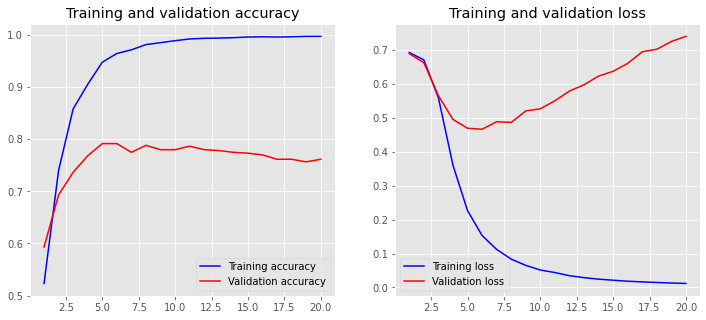

In [2052]:
plot_history(history)

In [2069]:
# New model
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size_1, 
                           output_dim = embedding_dim,
                           input_length=max_len))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_205"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_174 (Embedding)   (None, 42, 8)             34016     
                                                                 
 flatten_147 (Flatten)       (None, 336)               0         
                                                                 
 dense_403 (Dense)           (None, 8)                 2696      
                                                                 
 dense_404 (Dense)           (None, 1)                 9         
                                                                 
Total params: 36,721
Trainable params: 36,721
Non-trainable params: 0
_________________________________________________________________


In [2066]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=1)


history = model.fit(training_sentences, training_labels_final, 
                    epochs=num_epochs, validation_data=(testing_sentences, testing_labels_final), callbacks=early_stopping)




Epoch 1/20
75/75 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6908 - val_accuracy: 0.5533
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.7387 - val_loss: 0.6613 - val_accuracy: 0.7183
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.5480 - accuracy: 0.8650 - val_loss: 0.5467 - val_accuracy: 0.7483
Epoch 4/20
75/75 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.9125 - val_loss: 0.4776 - val_accuracy: 0.7667
Epoch 5/20
75/75 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9442 - val_loss: 0.4522 - val_accuracy: 0.7933
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.9663 - val_loss: 0.4525 - val_accuracy: 0.7967


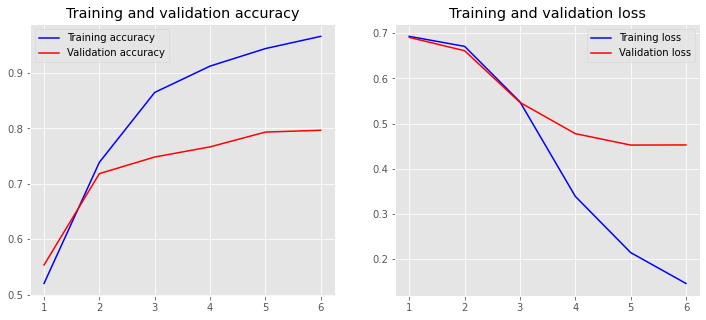

In [2067]:
plot_history(history)

In [2068]:
# Evaluate model
score = model.evaluate(testing_sentences, testing_labels_final)
score

19/19 [==============================] - 0s 1ms/step - loss: 0.4525 - accuracy: 0.7967


[0.4524901211261749, 0.79666668176651]